# Task 1

### Data Import

In [1]:
import json
import numpy as np
from sklearn import preprocessing

# Label Encoding
le = preprocessing.LabelEncoder()
le.fit(['non-rumour', 'rumour'])

# Training Data
trainLabels = {}
with open("train.label.json",  encoding="utf8") as f:
    trainLabels = json.load(f)
y_train = list(trainLabels.values())
y_train_binary = le.transform(y_train)

trainingData = []
trainingDataTweet = []
combinedDataTrain = []

with open("train.data.jsonl", encoding="utf8") as f:
    coreIndex = 0
    for line in f:
        row = json.loads(line)
        trainingData.append(row)
        text = ""
        for tweet in row:
            text += " " + tweet["text"]
        combinedDataTrain.append(text[1:])
        trainingDataTweet.append(row[0]["text"])
      
# Development Data    
devLabels = {}
with open("dev.label.json",  encoding="utf8") as f:
    devLabels = json.load(f)  
y_dev = list(devLabels.values())
y_dev_binary = le.transform(y_dev)
    
devData = []
devDataTweet = []
combinedDataDev = []
with open("dev.data.jsonl", encoding="utf8") as f:
    coreIndex = 0
    for line in f:
        row = json.loads(line)
        devData.append(row)
        text = ""
        for tweet in row:
            text += " " + tweet["text"]
        combinedDataDev.append(text[1:])
        devDataTweet.append(row[0]["text"])

# Test Data
testData = []
testDataTweet = []
combinedDataTest = []
with open("test.data.jsonl", encoding="utf8") as f:
    coreIndex = 0
    for line in f:
        row = json.loads(line)
        testData.append(row)
        text = ""
        for tweet in row:
            text += " " + tweet["text"]
        combinedDataTest.append(text[1:])
        testDataTweet.append(row[0]["text"])
        
print (f"Train Labels: {len(trainLabels)}, Train Data: {len(trainingData)}")
print (f"Dev Labels: {len(devLabels)}, Train Data: {len(devData)}")
print (f"Test Labels: {len(testData)}")

Train Labels: 4641, Train Data: 4641
Dev Labels: 580, Train Data: 580
Test Labels: 581


### Helper Methods

In [2]:
def exportResults(prediction):
    data = {}

    for i in range(len(testData)):
        data[testData[i][0]['id']] = prediction[i]

    with open('test-output.json', 'w') as outfile:
        json.dump(data, outfile)

### Preprocessing

#### Bag of words

In [3]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(trainingDataTweet)

# Converts text into bag of words representation using TF-IDF
x_train = tokenizer.texts_to_matrix(combinedDataTrain, mode="tfidf") #BOW representation
x_dev = tokenizer.texts_to_matrix(combinedDataDev, mode="tfidf") #BOW representation
x_test = tokenizer.texts_to_matrix(combinedDataTest, mode="tfidf") #BOW representation

# Vacobulary Size for futher processing 
vocab_size = x_train.shape[1]

#### word sequences

In [4]:
from keras.preprocessing.sequence import pad_sequences

#tokenise the input into word sequences
xseq_train = tokenizer.texts_to_sequences(combinedDataTrain)
xseq_dev = tokenizer.texts_to_sequences(combinedDataDev)
xseq_test = tokenizer.texts_to_sequences(combinedDataTest)

# Max length of the sentence
maxlen = max([len(vector) for vector in xseq_train])

# Padding to normalize sentence length
xseq_train = pad_sequences(xseq_train, padding='post', maxlen=maxlen)
xseq_dev = pad_sequences(xseq_dev, padding='post', maxlen=maxlen)
xseq_test = pad_sequences(xseq_test, padding='post', maxlen=maxlen)

### Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=0, solver="lbfgs", penalty="l2", C=1.0)
classifier.fit(x_train, y_train)
score = classifier.score(x_dev, y_dev)

print("Accuracy:", score)

Accuracy: 0.8879310344827587


In [ ]:
y_test_lr = classifier.predict(x_test)

# Export Results as zip
exportResults(y_test_lr)

### Feed-Forward Neural Network

#### Using Bag of words Pre-Processing

In [5]:
from keras.models import Sequential
from keras import layers

#model definition
model = Sequential(name="feedforward-bow-input")
model.add(layers.Dense(10, input_dim=vocab_size, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#since it's a binary classification problem, we use a binary cross entropy loss here
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "feedforward-bow-input"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                112750    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 112,761
Trainable params: 112,761
Non-trainable params: 0
_________________________________________________________________


In [7]:
#training
model.fit(x_train, y_train_binary, epochs=20, verbose=True, validation_data=(x_dev, y_dev_binary), batch_size=10)

loss, accuracy = model.evaluate(x_dev, y_dev_binary, verbose=False)
print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
465/465 [==============================] - 1s 2ms/step - loss: 0.4226 - accuracy: 0.8033 - val_loss: 0.3046 - val_accuracy: 0.8862
Epoch 2/20
465/465 [==============================] - 1s 2ms/step - loss: 0.1476 - accuracy: 0.9494 - val_loss: 0.3082 - val_accuracy: 0.8690
Epoch 3/20
465/465 [==============================] - 1s 2ms/step - loss: 0.0579 - accuracy: 0.9849 - val_loss: 0.3384 - val_accuracy: 0.8655
Epoch 4/20
465/465 [==============================] - 1s 2ms/step - loss: 0.0260 - accuracy: 0.9942 - val_loss: 0.3523 - val_accuracy: 0.8724
Epoch 5/20
465/465 [==============================] - 1s 2ms/step - loss: 0.0148 - accuracy: 0.9957 - val_loss: 0.3719 - val_accuracy: 0.8690
Epoch 6/20
465/465 [==============================] - 1s 2ms/step - loss: 0.0098 - accuracy: 0.9976 - val_loss: 0.3959 - val_accuracy: 0.8741
Epoch 7/20
465/465 [==============================] - 1s 2ms/step - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.4133 - val_accuracy: 0.8776
Epoch 

In [9]:
# Prediction
y_test_NN = model.predict(x_test)
y_test_NN = list(map(lambda label : int(round(label[0])), y_test_NN))
y_predict_nn = le.inverse_transform(y_test_NN)

# Export Results as zip
exportResults(y_predict_nn)

#### Using words sequences as input

In [6]:
embedding_dim = 10

#word order preserved with this architecture
model2 = Sequential(name="feedforward-sequence-input")
model2.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model2.add(layers.Flatten())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "feedforward-sequence-input"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5699, 10)          112740    
_________________________________________________________________
flatten (Flatten)            (None, 56990)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                569910    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 682,661
Trainable params: 682,661
Non-trainable params: 0
_________________________________________________________________


In [8]:
model2.fit(xseq_train, y_train_binary, epochs=20, verbose=True, validation_data=(xseq_dev, y_dev_binary), batch_size=10)

loss, accuracy = model2.evaluate(xseq_dev, y_dev_binary, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
465/465 [==============================] - 1s 2ms/step - loss: 0.5420 - accuracy: 0.7253 - val_loss: 0.3621 - val_accuracy: 0.8431
Epoch 2/20
465/465 [==============================] - 1s 2ms/step - loss: 0.2656 - accuracy: 0.8929 - val_loss: 0.3176 - val_accuracy: 0.8552
Epoch 3/20
465/465 [==============================] - 1s 2ms/step - loss: 0.1170 - accuracy: 0.9632 - val_loss: 0.3242 - val_accuracy: 0.8672
Epoch 4/20
465/465 [==============================] - 1s 2ms/step - loss: 0.0418 - accuracy: 0.9914 - val_loss: 0.3541 - val_accuracy: 0.8621
Epoch 5/20
465/465 [==============================] - 1s 2ms/step - loss: 0.0164 - accuracy: 0.9976 - val_loss: 0.3851 - val_accuracy: 0.8603
Epoch 6/20
465/465 [==============================] - 1s 2ms/step - loss: 0.0105 - accuracy: 0.9983 - val_loss: 0.4075 - val_accuracy: 0.8603
Epoch 7/20
465/465 [==============================] - 1s 2ms/step - loss: 0.0065 - accuracy: 0.9985 - val_loss: 0.4314 - val_accuracy: 0.8569
Epoch 

In [13]:
y_test_FF_Seq = model2.predict(xseq_test)
y_test_FF_Seq = list(map(lambda label : int(round(label[0])), y_test_FF_Seq))
y_predict_FF_Seq = le.inverse_transform(y_test_FF_Seq)

# Export Results as zip
exportResults(y_predict_FF_Seq)

### LSTM

In [7]:
from keras.layers import LSTM
from keras.layers import Bidirectional

#word order preserved with this architecture
model3 = Sequential(name="lstm")
model3.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model3.add(Bidirectional(LSTM(64)))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5699, 10)          112740    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               38400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 151,269
Trainable params: 151,269
Non-trainable params: 0
_________________________________________________________________


In [8]:
model3.fit(xseq_train, y_train_binary, epochs=20, verbose=True, validation_data=(xseq_dev, y_dev_binary), batch_size=10)

loss, accuracy = model3.evaluate(xseq_dev, y_dev_binary, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
  5/465 [..............................] - ETA: 26:55 - loss: 0.6869 - accuracy: 0.6200

KeyboardInterrupt: 

In [38]:
y_test_LSTM = model3.predict(xseq_test)
y_test_LSTM = list(map(lambda label : int(round(label[0])), y_test_LSTM))
y_predict_LSTM = le.inverse_transform(y_test_LSTM)

# Export Results as zip
exportResults(y_predict_LSTM)

# Task 2

### Importing Covid Data

In [13]:
covidData = []
covidDataTweet = []
covidDataCombined = []
with open("covid.data.jsonl", encoding="utf8") as f:
    coreIndex = 0
    for line in f:
        row = json.loads(line)
        covidData.append(row)       
        text = ""
        for tweet in row:
            text += " " + tweet["text"]
        covidDataCombined.append(text[1:])
        covidDataTweet.append(row[0]["text"])

### Preprocessing - Bag of words

In [14]:
covid_train = tokenizer.texts_to_matrix(covidDataTweet, mode="tfidf")

### Prediction

In [15]:
covid_predict_lr = classifier.predict(covid_train)

### Covid Data Tweet Classification

In [16]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re, collections

# Tweet Tokenizer
tt = TweetTokenizer()
stopwords = set(stopwords.words('english')) #note: stopwords are all in lowercase

rumourTweets = []
rumourTweetsCombined = []

nonRumourTweets = []
nonRumourTweetsCombined = []

rumourHashtags = collections.defaultdict(int)
nonRumourHashtags = collections.defaultdict(int)

for i in range(len(covid_predict_lr)):
    if (covid_predict_lr[i] == 'rumour'):
        rumourTweets.append(covidData[i][0])
        rumourTweetsCombined.append(covidData[i])
    else:
        nonRumourTweets.append(covidData[i][0])
        nonRumourTweetsCombined.append(covidData[i])
    for hashtag in covidData[i][0]['entities']['hashtags']:
        if (covid_predict_lr[i] == 'rumour'):
            rumourHashtags[hashtag['text'].lower()] += 1
        else: 
            nonRumourHashtags[hashtag['text'].lower()] += 1

### Hashtag Analysis

In [20]:
print ("Top 10 Rumour hashtags", [hashtag[0] for hashtag in sorted(rumourHashtags.items(), key=lambda el: el[1], reverse=True)[:10]])
print ("\n")
print ("Top 10 Non Rumour hashtags", [hashtag[0] for hashtag in sorted(nonRumourHashtags.items(), key=lambda el: el[1], reverse=True)[:10]])
print ("\n")
print ("Uncommon tweets in Non-Rumour Hashtags")
print ([tag for tag in rumourHashtags.keys() if tag not in nonRumourHashtags.keys()])

Top 10 Rumour hashtags ['covid19', 'coronavirus', 'breaking', 'cdnpoli', 'covid', 'china', 'wuhan', 'staysafeug', 'ccpvirus', 'covidー19']


Top 10 Non Rumour hashtags ['covid19', 'coronavirus', 'breaking', 'covid', 'china', 'covid_19', 'covidー19', 'stayhome', 'coronaviruspandemic', 'lockdown']


Uncommon tweets in Non-Rumour Hashtags
['udmchiefwhip', 'weshallovercome', 'ntpol', 'selectionbias', 'covid19aus', 'ct', 'ny', 'nstnation', 'stanfordmedlive', 'uganda', 'death', 'firforsushantunder302', 'svp', 'racisminchina', 'africans', 'iranian', 'christian', 'convert', 'asylum', 'indonesia', 'trumprally', 'ithadtobesaid', 'bc', 'staysafestayhome', 'vicpol', 'springst', 'bharatwilldefeatcorona', 'borneobulletin', 'coalcityconnect', 'wethepeople', 'novax', 'chocolatehummus', 'traderjoes', 'dc', 'speakingmoistly', 'azerbaijan', 'armenia', 'tabligijamaat', 'markaz', 'pm', 'forthepeople', 'ncdctakeresponsibility', 'abbakyariburial', 'slimcase', 'covidvic', 'bbcnewssix', '레드벨벳', '예리', 'yeri', 'ch

### Sentiment Analysis

In [21]:
import flair
from collections import defaultdict
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

rumourSentimentStats = defaultdict(int)

for tweet in rumourTweets:
    s = flair.data.Sentence(tweet['text'])
    flair_sentiment.predict(s)
    if str(s.labels[0])[0] == 'N':
        rumourSentimentStats['Negative'] += 1
    else:
        rumourSentimentStats['Positive'] += 1
    
rumourSentimentStats

2021-05-12 20:23:04,242 loading file C:\Users\sharo\.flair\models\sentiment-en-mix-distillbert_4.pt


defaultdict(int, {'Negative': 1204, 'Positive': 214})

In [33]:
nonRumourSentimentStats = defaultdict(int)

for tweet in nonRumourTweets:
    s = flair.data.Sentence(tweet['text'])
    flair_sentiment.predict(s)
    if str(s.labels[0])[0] == 'N':
        nonRumourSentimentStats['Negative'] += 1
    else:
        nonRumourSentimentStats['Positive'] += 1
        
nonRumourSentimentStats

defaultdict(int, {'Negative': 11911, 'Positive': 4129})

In [34]:
print (f"Percentage of Negative Tweets in Rumours: {rumourSentimentStats['Negative']/(rumourSentimentStats['Positive'] + rumourSentimentStats['Negative'])}")
print (f"Percentage of Negative Tweets in Non-Rumours: {nonRumourSentimentStats['Negative']/(nonRumourSentimentStats['Positive'] + nonRumourSentimentStats['Negative'])}")

Percentage of Negative Tweets in Rumours: 0.849083215796897
Percentage of Negative Tweets in Non-Rumours: 0.7425810473815462


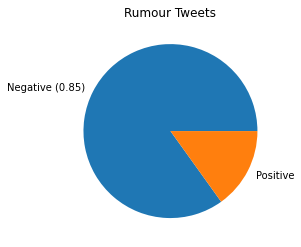

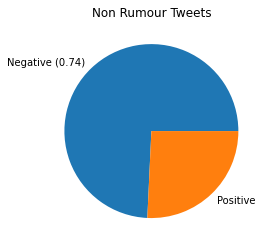

In [35]:
import numpy as np

rumourPercent = round(rumourSentimentStats['Negative']/(rumourSentimentStats['Positive'] + rumourSentimentStats['Negative']),2)
nonRumourPercent = round(nonRumourSentimentStats['Negative']/(nonRumourSentimentStats['Positive'] + nonRumourSentimentStats['Negative']),2)

plt.title("Rumour Tweets")
plt.pie(np.array([rumourSentimentStats['Negative'], rumourSentimentStats['Positive']]), labels = [f"Negative ({rumourPercent})", "Positive"])
plt.show() 

plt.title("Non Rumour Tweets")
plt.pie(np.array([nonRumourSentimentStats['Negative'], nonRumourSentimentStats['Positive']]), labels = [f"Negative ({nonRumourPercent})", "Positive"])
plt.show() 

### Topic Classification

In [22]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re, collections

tt = TweetTokenizer()
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

# Corpus Creation for topic analysis
corpus = ""
for tweet in rumourTweets:
    unigramText = ""
    for word in tt.tokenize(tweet['text']):
        wordProcessed = word.lower()
        if wordProcessed.isalpha():
            unigramText += wordProcessed + " "

    corpus += unigramText

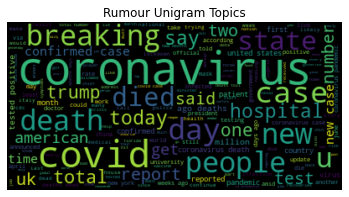

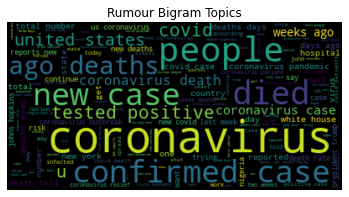

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Unigram Topics
wordcloud = WordCloud(stopwords = STOPWORDS).generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Rumour Unigram Topics")
plt.show()

# Bigram Topics
wordcloud = WordCloud(stopwords = STOPWORDS, collocation_threshold = 3).generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Rumour Bigram Topics")
plt.show()

In [24]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

nonRumourCorpus = ""
for tweet in nonRumourTweets:
    unigramText = ""
    for word in tt.tokenize(tweet['text']):
        wordProcessed = word.lower()
        if wordProcessed.isalpha():
            unigramText += wordProcessed + " "

    nonRumourCorpus += unigramText

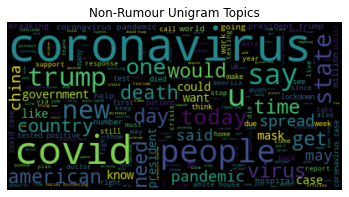

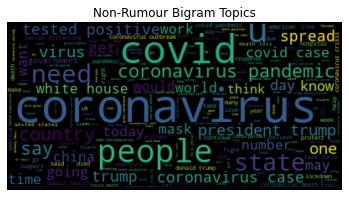

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Unigram Topics
wordcloud = WordCloud(stopwords = STOPWORDS).generate(nonRumourCorpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Non-Rumour Unigram Topics")
plt.axis("off")
plt.show()

# Bigram Topics
wordcloud = WordCloud(stopwords = STOPWORDS, collocation_threshold = 3).generate(nonRumourCorpus)
plt.figure()
plt.title("Non-Rumour Bigram Topics")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Propagation Analysis

#### Rumour Tweet Propagation Analysis

In [26]:
from datetime import datetime

propagationTimes = []
for instance in rumourTweetsCombined:
    propagationSeconds = [0]
    rootTweetDatetime = datetime.strptime(instance[0]['created_at'], '%a %b %d %X %z %Y')
    for tweet in instance[1:]:
        subTweetDatetime = datetime.strptime(tweet['created_at'], '%a %b %d %X %z %Y')
        propagationSeconds.append((subTweetDatetime - rootTweetDatetime).total_seconds())
    propagationTimes.append(sorted(propagationSeconds))

maxLength = max([len(instance) for instance in propagationTimes])

finalPropagationTime = []
for i in range(maxLength):
    count = 0
    total = 0
    for instance in propagationTimes:
        if i < len(instance):
            count += 1
            total += instance[i]
    if total/count > 0:
        finalPropagationTime.append(total/count)

#### Non- Rumour Tweet Propagation Analysis

In [27]:
propagationTimes2 = []
for instance in nonRumourTweetsCombined:
    propagationSeconds = [0]
    rootTweetDatetime = datetime.strptime(instance[0]['created_at'], '%a %b %d %X %z %Y')
    for tweet in instance[1:]:
        subTweetDatetime = datetime.strptime(tweet['created_at'], '%a %b %d %X %z %Y')
        propagationSeconds.append((subTweetDatetime - rootTweetDatetime).total_seconds())
    propagationTimes2.append(sorted(propagationSeconds))

maxLength2 = max([len(instance) for instance in propagationTimes2])

finalPropagationTime2 = []
for i in range(maxLength2):
    count = 0
    total = 0
    for instance in propagationTimes2:
        if i < len(instance):
            count += 1
            total += instance[i]
    if total/count > 0:
        finalPropagationTime2.append(total/count)

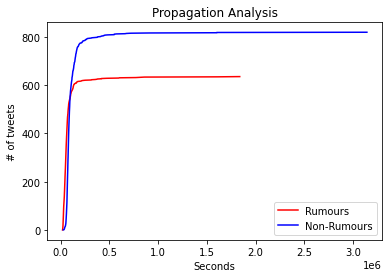

In [28]:
x = np.array([i for i in range(len(finalPropagationTime))])
y = np.array(sorted(finalPropagationTime))
plt.xlabel("Seconds")
plt.ylabel("# of tweets")
plt.title("Propagation Analysis")
plt.plot(y, x,color="red",label="Rumours")
x2 = np.array([i for i in range(len(finalPropagationTime2))])
y2 = np.array(sorted(finalPropagationTime2))
plt.plot(y2, x2,"blue",label="Non-Rumours")
plt.legend()
plt.show()

### User Analysis

In [29]:
from collections import defaultdict

rumourUserStats = defaultdict(int)

for tweet in rumourTweets:
    if tweet["user"]["verified"]:
        rumourUserStats["verified"] += 1
    if tweet["user"]["geo_enabled"]:
        rumourUserStats["geo_enabled"] += 1 
    if tweet["user"]["following"]:
        rumourUserStats["following"] += 1
    if tweet["user"]["protected"]:
        rumourUserStats["protected"] += 1
    rumourUserStats["retweet_count"] += tweet["retweet_count"]
    rumourUserStats["hashTagsPerTweet"] += len(tweet['entities']['hashtags'])
    rumourUserStats["user_mentions"] += len(tweet["entities"]["user_mentions"])
    rumourUserStats["favorite_count"] += tweet["favorite_count"]
    rumourUserStats["friends_count"] += tweet["user"]["friends_count"]
 
print ("Rumour Tweet Stats")
print (f"% of verified Users: {(rumourUserStats['verified']/len(rumourTweets)) *100}")
print (f"% of geo enabled Users: {(rumourUserStats['geo_enabled']/len(rumourTweets)) *100}")
print (f"% of following Users: {(rumourUserStats['following']/len(rumourTweets)) *100}")
print (f"% of protected Users: {(rumourUserStats['protected']/len(rumourTweets)) *100}")
print (f"Avg number of retweet count: {(rumourUserStats['retweet_count']/len(rumourTweets))}")
print (f"Avg number of hashTagsPerTweet Users: {(rumourUserStats['hashTagsPerTweet']/len(rumourTweets))}")
print (f"Avg number of user_mentions Users: {(rumourUserStats['user_mentions']/len(rumourTweets))}")
print (f"Avg number of fav counts Users: {(rumourUserStats['favorite_count']/len(rumourTweets))}")
print (f"Avg number of friends_count Users: {(rumourUserStats['friends_count']/len(rumourTweets))}")

nonRumourUserStats = defaultdict(int)

for tweet in nonRumourTweets:
    if tweet["user"]["verified"]:
        nonRumourUserStats["verified"] += 1
    if tweet["user"]["geo_enabled"]:
        nonRumourUserStats["geo_enabled"] += 1
    if tweet["user"]["following"]:
        nonRumourUserStats["following"] += 1 
    if tweet["user"]["protected"]:
        nonRumourUserStats["protected"] += 1
    if tweet["user"]["protected"]:
        nonRumourUserStats["protected"] += 1
    nonRumourUserStats["retweet_count"] += tweet["retweet_count"]
    nonRumourUserStats["hashTagsPerTweet"] += len(tweet['entities']['hashtags'])
    nonRumourUserStats["user_mentions"] += len(tweet["entities"]["user_mentions"])
    nonRumourUserStats["favorite_count"] += tweet["favorite_count"]
    nonRumourUserStats["friends_count"] += tweet["user"]["friends_count"]

print ("\nNon Rumour Tweet Stats")        
print (f"% of verified Users: {(nonRumourUserStats['verified']/len(nonRumourTweets)) *100}")
print (f"% of geo enabled Users: {(nonRumourUserStats['geo_enabled']/len(nonRumourTweets)) *100}")
print (f"% of following Users: {(nonRumourUserStats['following']/len(nonRumourTweets)) *100}")
print (f"% of protected Users: {(nonRumourUserStats['protected']/len(nonRumourTweets)) *100}")
print (f"Avg number of retweet count: {(nonRumourUserStats['retweet_count']/len(nonRumourTweets))}")
print (f"Avg number of hashTagsPerTweet Users: {(nonRumourUserStats['hashTagsPerTweet']/len(nonRumourTweets))}")
print (f"Avg number of user_mentions Users: {(nonRumourUserStats['user_mentions']/len(nonRumourTweets))}")
print (f"Avg number of fav counts Users: {(nonRumourUserStats['favorite_count']/len(nonRumourTweets))}")
print (f"Avg number of fav counts Users: {(nonRumourUserStats['favorite_count']/len(nonRumourTweets))}")
print (f"Avg number of friends_count Users: {(nonRumourUserStats['friends_count']/len(nonRumourTweets))}")

Rumour Tweet Stats
% of verified Users: 75.17630465444289
% of geo enabled Users: 60.57827926657263
% of following Users: 0.7052186177715092
% of protected Users: 0.0
Avg number of retweet count: 2787.5169252468263
Avg number of hashTagsPerTweet Users: 0.5
Avg number of user_mentions Users: 0.22425952045133993
Avg number of fav counts Users: 9435.603667136813
Avg number of friends_count Users: 7615.849083215797

Non Rumour Tweet Stats
% of verified Users: 74.27680798004988
% of geo enabled Users: 58.02369077306733
% of following Users: 1.2780548628428927
% of protected Users: 0.0
Avg number of retweet count: 3716.262967581047
Avg number of hashTagsPerTweet Users: 0.4913965087281795
Avg number of user_mentions Users: 0.2523690773067332
Avg number of fav counts Users: 13856.861907730674
Avg number of fav counts Users: 13856.861907730674
Avg number of friends_count Users: 7886.991458852868


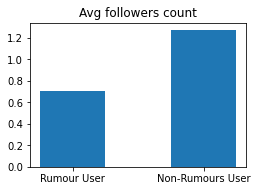

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,0.5,0.5])
ax.set_title('Avg followers count')
categories = ['Rumour User', 'Non-Rumours User']
followers = [(rumourUserStats['following']/len(rumourTweets)) *100, (nonRumourUserStats['following']/len(nonRumourTweets)) *100]
ax.bar(categories,followers,width = 0.5)
plt.show()

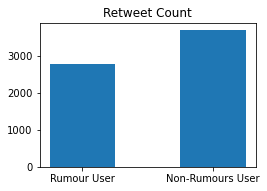

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,0.5,0.5])
ax.set_title('Retweet Count')
categories = ['Rumour User', 'Non-Rumours User']
followers = [rumourUserStats['retweet_count']/len(rumourTweets), nonRumourUserStats['retweet_count']/len(nonRumourTweets)]
ax.bar(categories,followers,width = 0.5)
plt.show()